In [104]:
import luigi
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(0, '/home/fbuonerba/codes/')
from mp_functions import upload_log_return, upload_factor_loadings
from coinapi_v1 import CoinAPIv1
import datetime
from datetime import datetime, timedelta
import time
import calendar
import json
import urllib.request
import multiprocessing as mp
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
with open('/home/fbuonerba/codes/meta_data/new_coins.txt') as ff:
    coins=json.load(ff)
bad=['NPXS','MKR','VET','RHOC', 'ONT', 'ZIL', 'NANO', 'BAT','BCD','XTZ']
coins=np.array(coins)
where=[i for i in range(len(coins)) if coins[i] in bad]
coins=np.delete(coins, where)

prettybad=['BCN','DCR','BTG','BTM','XVG']
prettywhere=[i for i in range(len(coins)) if coins[i] in prettybad]
coins=np.delete(coins, prettywhere)
quotes=['BTC']

In [106]:

#sysm=[str(coin)+'_'+str(quote) for coin in coins for quote in quotes]
def get_returns(beg,end):
    #weights=0 or 1
    t=beg
    matrix=[]
    while t<=end+1:
        ret_t=[]
        for base in coins:
            for quote in quotes:
                returns=upload_log_return(t, base, quote, 86400)
                if np.isnan(returns)==True:
                    returns=0
                ret_t.append(returns)
                #print(base,quote)
        matrix.append(ret_t)
        t+=86400
    R=np.array(matrix)
    norms=np.linalg.norm(R, axis=0)
    W=np.where(norms==0)
    ##careful here: W might change over different times!
    ######
    R=np.delete(R, W, axis=1) 
    std=np.std(R, axis=0)
    #return degenerate_indices, returns
    return(W, R)

#####W[0]=those pairs for which no trading activity is recorded
#VET,NPXS have no data for this time period. Indeed they were ranked low on cmc.
#then BTC has no data vs BTC, the rest have no data vs USD.


In [108]:
#####Factors: January to April#####
#####log_mkcap and coin_ratio computed averaging.
#####Those are the good ones!

########removing coin ratio to see what happens!!

factors=[]
keys=['returns_variance', 'returns_strength', 'rates_high_low','turnover', 'log_marketcap']#,'coin_ratio']
folder='/home/fbuonerba/factor_loadings/factors_'

def get_raw_factors(beg,end,W):
    factors=[]
    std=[]
    for coin in coins:
        for quote in quotes:
            with open(folder+coin+'_'+quote+'_'+str(beg)+'_'+str(end)+'_86400.txt') as data:
                fac=json.load(data)
            ordr=[]
            for key in keys:
                if key=='returns_variance':
                    E=fac[key]**.5
                    std.append(E)
                else:
                    E=fac[key]
                ordr.append(E)
            factors.append(ordr)
    factors=np.array(factors)
    std=np.array(std)
    factors=np.delete(factors, W, axis=0)
    std=np.delete(std, W, axis=0)
    std=std.reshape(-1,1)
    #####here we do normalization using z-score along coin axis#####
    factors[np.where(np.isnan(factors)==True)]=0
    
    ###There are two NaN entries, corresponding to coin ratio of BCD, 43rd position.
    ###In a random cmc_historical, the supply is nan. Confirmed on cmc website chart:
    #at the time BCD was doing poorly - in march it was ranked 1250th.
    return(std, factors)

def get_processed_factors(beg,end,W):
    std, factors=get_raw_factors(beg,end,W)
    factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5
    return(std, factors)
###std has a few outliers, notably BAT/BTC and BCD/both.

In [ ]:
#####Factors: January to April#####
#####log_mkcap and coin_ratio computed on the day.
factors=[]
new_keys=['returns_variance', 'returns_strength', 'rates_high_low','turnover']
exact_keys=['log_mkcap_exact_','coin_ratio_exact_']
folder='/home/fbuonerba/factor_loadings/factors_'
exact_folder='/home/fbuonerba/factor_loadings/'
def get_raw_barra_factors(beg,end,W):
    factors=[]
    std=[]
    for coin in coins:
        for quote in quotes:
            with open(folder+coin+'_'+quote+'_'+str(beg)+'_'+str(end)+'_86400.txt') as data:
                fac=json.load(data)
            ordr=[]
            for key in new_keys:
                if key=='returns_variance':
                    E=fac[key]**.5
                    std.append(E)
                else:
                    E=fac[key]
                ordr.append(E)
            ####exact factors####
            with open(exact_folder+exact_keys[0]+coin+'_'+quote+'_'+str(end)+'.txt') as ff:
                exc=json.load(ff)
            ordr.append(exc)
            with open(exact_folder+exact_keys[1]+coin+'_'+str(end)+'.txt') as ff:
                exc=json.load(ff)
            ordr.append(exc)
            factors.append(ordr)
    factors=np.array(factors)
    std=np.array(std)
    factors=np.delete(factors, W, axis=0)
    std=np.delete(std, W, axis=0)
    std=std.reshape(-1,1)
    factors[np.where(np.isnan(factors)==True)]=0
    return(std, factors)
    ###There are two NaN entries, corresponding to coin ratio of BCD, 43rd position.
    ###In a random cmc_historical, the supply is nan. Confirmed on cmc website chart:
    #at the time BCD was doing poorly - in march it was ranked 1250th.
def get_processed_barra_factors(beg,end,W):
    std, factors=get_raw_barra_factors(beg,end,W)
    factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5
    return(std, factors)

In [ ]:
####regression against returns from April 2nd to May 2nd; loadings computed on April 1st.####
def get_stats(beg,end,beg1,end1,method, weight):
    #method=averaged or barra
    #weight=0 or 1
    W,R=get_returns(beg,end)
    if method=='averaged':
        std, factors=get_processed_factors(beg1,end1,W)
    elif method=='barra':
        std, factors=get_processed_barra_factors(beg1,end1,W)
    total_factors=np.hstack((factors, np.ones(factors.shape[0]).reshape(-1,1)))
    if weight==1:
        total_factors=total_factors*(std**-1)
        R=R*((std.T)**-1)
    reg=linear_model.LinearRegression()
    #sklearn automatically preprocesses the data by removing np.mean(axis=0)#
    reg.fit(total_factors,R.T)
    beta=reg.coef_
    inter=reg.intercept_
    inter=inter.reshape(-1,1)
    total_beta=np.hstack((beta,inter)) 
    R_hat=reg.predict(total_factors) 
    print(reg.score(total_factors,R.T))#predicted returns = (tot_fact).(tot_beta.T)
    #####compute r_squared and F_scores#####
    #numpy and sklearn have built-in functions computing r2.
    #reg.score computes the mean along axis=0
    #r2_score computes the mean over full matrix. Example:
    #r2_score(R.T,R_hat1,multioutput='variance_weighted')
    residuals=R.T-R_hat
    R_mean=np.mean(R.T,axis=0) #daily average return
    tss=np.sum( (R.T-R_mean)**2, axis=0 ) #daily total_sum_squares
    rss=np.sum( (R.T-R_hat)**2, axis=0 ) #daily residual_sum_squares ~ var residuals
    r2=1-rss/tss #daily R^2
    cov_residuals=np.dot(residuals.T,residuals)/(factors.shape[0]-factors.shape[1])#daily
    var_residuals=cov_residuals.diagonal() #daily unbiased variance of residuals
    F=((tss-rss)/factors.shape[1])/var_residuals #daily F-scores
    #####compute z_scores, using total_beta and total_factors for compactness#####
    inv=np.linalg.inv(np.dot(total_factors.T,total_factors)) #usual (X^T.X)^{-1}
    cov_beta=np.tensordot(inv,var_residuals, axes=0) #daily covariance of betas: inv*var(residual)
    var_beta=cov_beta.diagonal() #daily variance of betas
    std_beta=np.sqrt(var_beta) #daily standard errors
    #z_scores=total_beta/std_beta
    return(total_beta, total_factors, R_hat, r2, F)#, z_scores)
    
# df_list=[]
# for t in range(30):
#     df=pd.DataFrame()
#     df1=pd.DataFrame()
#     df['factor_name']=['returns_variance', 'returns_strength', 'returns_high_low', 'turnover', 'average_log_mkcap', 'average_coin_ratio','1']
#     df['beta']=total_beta[t]
#     df['std_error']=std_beta[t]
#     df['z_score']=z_scores[t]
#     df1['r_squared']=np.array([r2[t]])
#     df1['F_score']=np.array([F[t]])
#     df_list.append([df,df1])
# r2_barra_wt=r2

**********
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.573
Model:                            WLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     6.982
Date:                Tue, 18 Sep 2018   Prob (F-statistic):           0.000297
Time:                        21:50:21   Log-Likelihood:                 79.648
No. Observations:                  32   AIC:                            -147.3
Df Residuals:                      26   BIC:                            -138.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0474      0.004    -11.0

**********
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.215
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.330
Time:                        21:50:21   Log-Likelihood:                 83.042
No. Observations:                  32   AIC:                            -154.1
Df Residuals:                      26   BIC:                            -145.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.004     -1.5

**********
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            WLS   Adj. R-squared:                 -0.118
Method:                 Least Squares   F-statistic:                    0.3457
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.880
Time:                        21:50:21   Log-Likelihood:                 61.099
No. Observations:                  32   AIC:                            -110.2
Df Residuals:                      26   BIC:                            -101.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0447      0.008     -5.8

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.378
Model:                            WLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     3.164
Date:                Tue, 18 Sep 2018   Prob (F-statistic):             0.0231
Time:                        21:50:21   Log-Likelihood:                 81.019
No. Observations:                  32   AIC:                            -150.0
Df Residuals:                      26   BIC:                            -141.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.004      0.604      0.5

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            WLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.621
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.190
Time:                        21:50:21   Log-Likelihood:                 69.972
No. Observations:                  32   AIC:                            -127.9
Df Residuals:                      26   BIC:                            -119.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0104      0.006     -1.774      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.216
Model:                            WLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1.437
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.244
Time:                        21:50:22   Log-Likelihood:                 86.781
No. Observations:                  32   AIC:                            -161.6
Df Residuals:                      26   BIC:                            -152.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0156      0.003     -4.583      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.217
Model:                            WLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.444
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.242
Time:                        21:50:22   Log-Likelihood:                 67.357
No. Observations:                  32   AIC:                            -122.7
Df Residuals:                      26   BIC:                            -113.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0227      0.006      3.566      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.486
Model:                            WLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     4.922
Date:                Tue, 18 Sep 2018   Prob (F-statistic):            0.00266
Time:                        21:50:22   Log-Likelihood:                 74.465
No. Observations:                  32   AIC:                            -136.9
Df Residuals:                      26   BIC:                            -128.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0731      0.005    -14.349      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.197
Model:                            WLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.274
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.305
Time:                        21:50:22   Log-Likelihood:                 61.782
No. Observations:                  32   AIC:                            -111.6
Df Residuals:                      26   BIC:                            -102.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0425      0.007     -5.681      0.0

**********
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.380
Model:                            WLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     3.191
Date:                Tue, 18 Sep 2018   Prob (F-statistic):             0.0223
Time:                        21:50:22   Log-Likelihood:                 85.535
No. Observations:                  32   AIC:                            -159.1
Df Residuals:                      26   BIC:                            -150.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0087      0.004     -2.4

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.603
Model:                            WLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     7.893
Date:                Tue, 18 Sep 2018   Prob (F-statistic):           0.000124
Time:                        21:50:22   Log-Likelihood:                 74.575
No. Observations:                  32   AIC:                            -137.2
Df Residuals:                      26   BIC:                            -128.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0460      0.005     -9.189      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.286
Model:                            WLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.080
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.100
Time:                        21:50:22   Log-Likelihood:                 73.380
No. Observations:                  32   AIC:                            -134.8
Df Residuals:                      26   BIC:                            -126.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0142      0.005     -2.750      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.228
Model:                            WLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.534
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.214
Time:                        21:50:22   Log-Likelihood:                 70.815
No. Observations:                  32   AIC:                            -129.6
Df Residuals:                      26   BIC:                            -120.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0571      0.006    -10.219      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.018
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.427
Time:                        21:50:22   Log-Likelihood:                 59.187
No. Observations:                  32   AIC:                            -106.4
Df Residuals:                      26   BIC:                            -97.58
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.008      1.264      0.2

**********
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.348
Model:                            WLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     2.780
Date:                Tue, 18 Sep 2018   Prob (F-statistic):             0.0385
Time:                        21:50:22   Log-Likelihood:                 90.077
No. Observations:                  32   AIC:                            -168.2
Df Residuals:                      26   BIC:                            -159.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0150      0.003      4.9

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            WLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.229
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.324
Time:                        21:50:22   Log-Likelihood:                 78.723
No. Observations:                  32   AIC:                            -145.4
Df Residuals:                      26   BIC:                            -136.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.004      0.170      0.8

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            WLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     1.849
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.138
Time:                        21:50:22   Log-Likelihood:                 52.044
No. Observations:                  32   AIC:                            -92.09
Df Residuals:                      26   BIC:                            -83.29
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0142      0.010     -1.428      0.1

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     1.502
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.224
Time:                        21:50:22   Log-Likelihood:                 63.217
No. Observations:                  32   AIC:                            -114.4
Df Residuals:                      26   BIC:                            -105.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0996      0.007    -14.183      0.0

**********
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            WLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.7338
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.605
Time:                        21:50:22   Log-Likelihood:                 81.136
No. Observations:                  32   AIC:                            -150.3
Df Residuals:                      26   BIC:                            -141.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.004     -0.7

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.153
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.358
Time:                        21:50:22   Log-Likelihood:                 68.968
No. Observations:                  32   AIC:                            -125.9
Df Residuals:                      26   BIC:                            -117.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0373      0.006      6.408      0.0

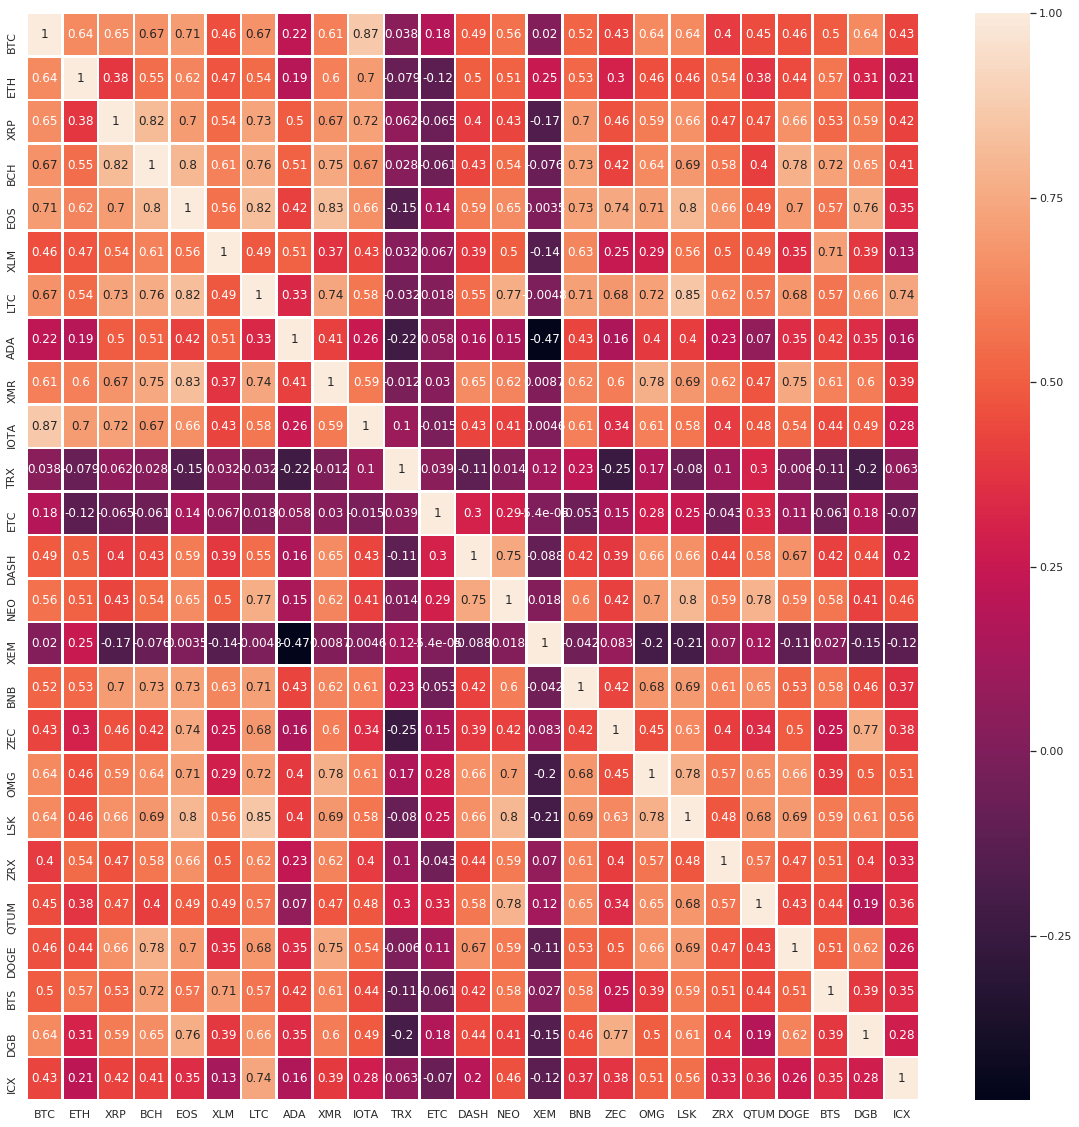

In [148]:
import statsmodels.api as sm
#stats for log_returns in terms of BTC
methods=['averaged','barra']
weights=[0,1]
T=list(range(24))
beg=[1522540800+t*604800 for t in T]
end=[1522540800+(t+1)*604800 for t in T]
beg1=[1515283200+t*604800 for t in T]
end1=[1522540800+t*604800 for t in T]
###statsmodels works if do one regression per day, i.e. y a vector###
ret=[]
e=np.exp(1)
for j in range(10,24):
    W,R=get_returns(beg[j],end[j])
    #print(W)
    sys.stdout.flush()
    std, factors=get_processed_factors(beg1[j],end1[j],W)
    print('**********')
    sys.stdout.flush()
    X=factors
    X = sm.add_constant(X)
    for i in range(7):
        Y=R[i].T
        ret.append(Y)
        #est_nowt=sm.WLS(Y,X).fit()
        est_wt=sm.WLS(Y,X, weights=1/std**2).fit()
        error=est_wt.predict()-Y
        #look for heteroskedasticity!
        #plt.scatter(est_nowt.predict(),error)
        #plt.scatter(est_wt.predict(), error)
        #plt.show()
        print(est_wt.summary())
        #print(i,est_wt.rsquared)
#    #check errors are independent of factors!
#     for k in range(X.shape[1]):
#         if k>0:
#             print(keys[k-1])
#         plt.scatter(range(len(X.T[k])),X.T[k])#, error)
#         plt.show()
ret=np.array(ret)

sns.set()
fig, ax = plt.subplots(figsize=(20,20))
ZZZ=sns.heatmap(np.corrcoef(ret.T[:25,:25]), annot = True, linewidths=1.5, ax=ax,xticklabels=coins[:25], yticklabels=coins[:25])
#ZZZ.figure.savefig("corr_heatmap.png")


In [14]:
#correlation time-wise:
RET=[]
RET_hat=[]
W_special,R_special=get_returns(beg[0],end[0])
for i in range(4):
    W,R=get_returns(beg[i],end[i])
    #print(W)
    RET.append(R)
    std, factors=get_processed_factors(beg1[i],end1[i],W)
    X=factors
    X = sm.add_constant(X)
    for j in range(7):
        Y=R[j].T
        est_wt=sm.WLS(Y,X, weights=1/std**2).fit()
        RET_hat.append(est_wt.predict())
        print(est_wt.rsquared)
    #print(np.delete(coins,W))


RET=np.array(RET)
print(RET.shape)
shape=RET.shape[-1]
RET=RET.reshape(-1,shape)
RET_hat=np.array(RET_hat)
print(RET.shape, RET_hat.shape)
COR=np.corrcoef(RET.T,RET_hat.T)
print(COR.shape)
COR[shape:,:shape].diagonal()

0.17800922709246214
0.08848991145398888
0.09520476884942775
0.0968652937710649
0.08068927499034861
0.11138942055299095
0.3292901663535257
0.030052678837882985
0.28914906583338074
0.05844496246128439
0.05078891403032504
0.21477528886405128
0.04912709145611183
0.26287452238877196
0.15629472802934885
0.035119435034373314
0.11773701985321527
0.10051638640390259
0.43562263548189406
0.03249141800203581
0.07151661347787619
0.5434610184406063
0.2069009185303169
0.0898894464602571
0.07677939273941714
0.13614506500400714
0.031212128902083802
0.060297718976419
(4, 7, 37)
(28, 37) (28, 37)
(74, 74)


array([ 0.73209955,  0.84619595,  0.18617049,  0.41205866,  0.69837016,
        0.71458918,  0.54516659,  0.81759447,  0.74879721,  0.2497138 ,
        0.80102434,  0.89144136,  0.65489725,  0.80642208,  0.37965584,
        0.76057236,  0.39868212,  0.69275925,  0.5199241 ,  0.68083405,
        0.9834629 , -0.10765015,  0.69494678,  0.75173869,  0.51992831,
        0.77518126,  0.57657441, -0.0531994 ,  0.46835146,  0.57904234,
        0.63746911,  0.62071255,  0.38842946,  0.42720016,  0.7583501 ,
        0.37453692,  0.76570665])

predicted vs error


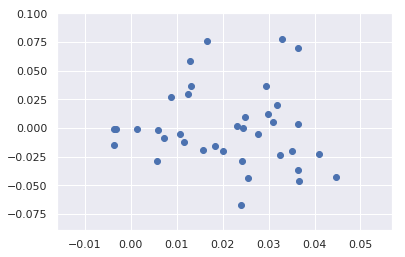

QQ plot for error normality


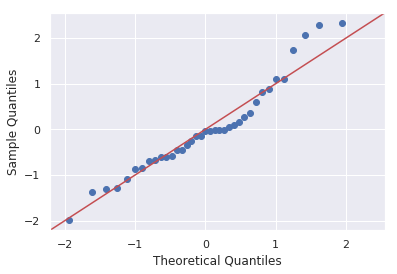

predicted vs standardized error for homoskedast.


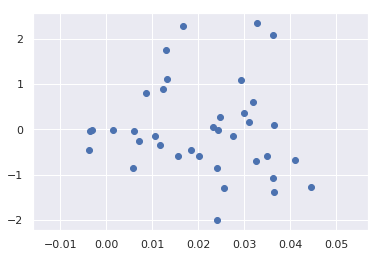

*************************
predicted vs error


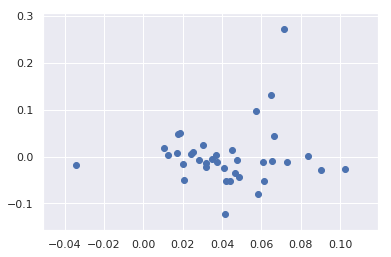

QQ plot for error normality


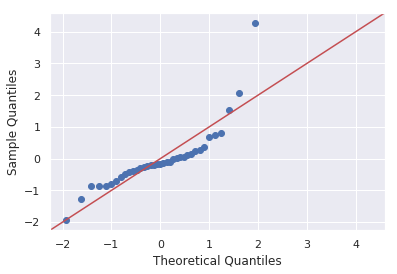

predicted vs standardized error for homoskedast.


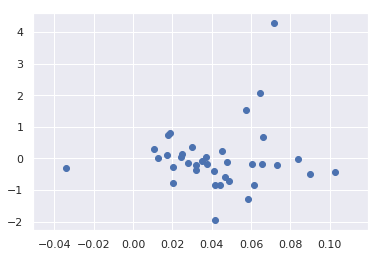

*************************
predicted vs error


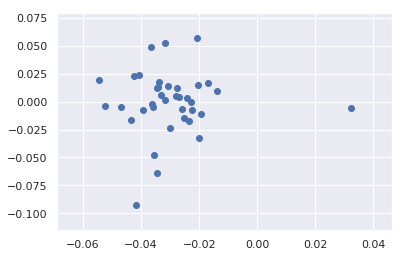

QQ plot for error normality


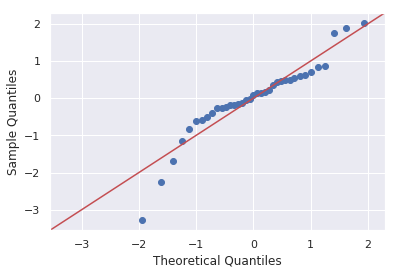

predicted vs standardized error for homoskedast.


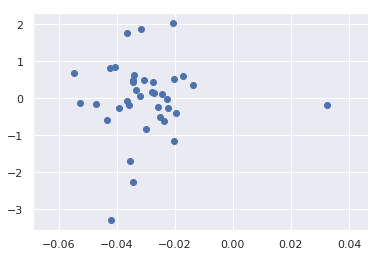

*************************
predicted vs error


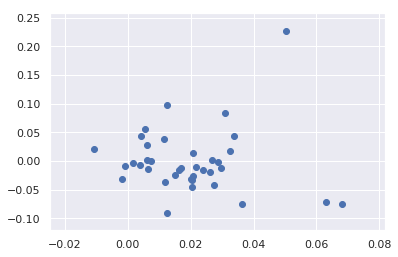

QQ plot for error normality


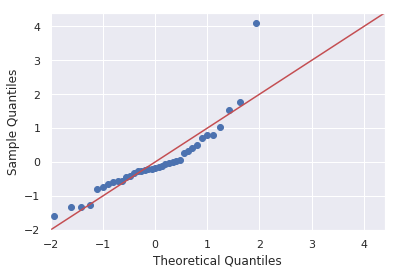

predicted vs standardized error for homoskedast.


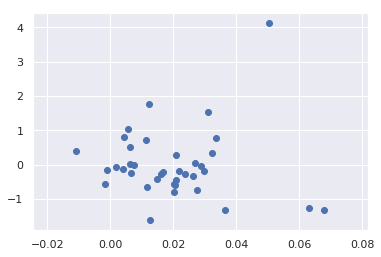

*************************
predicted vs error


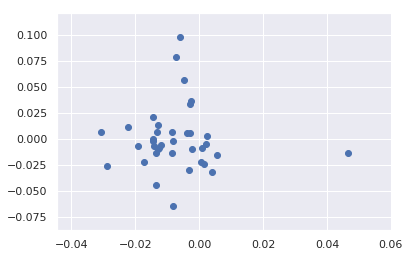

QQ plot for error normality


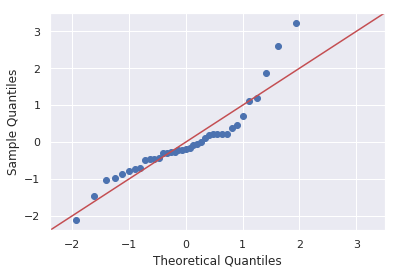

predicted vs standardized error for homoskedast.


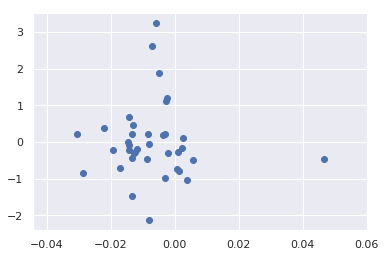

*************************
predicted vs error


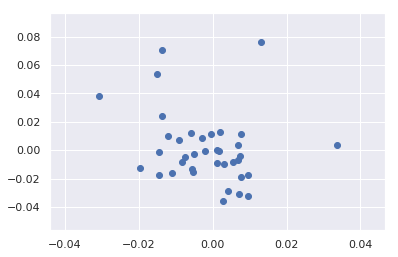

QQ plot for error normality


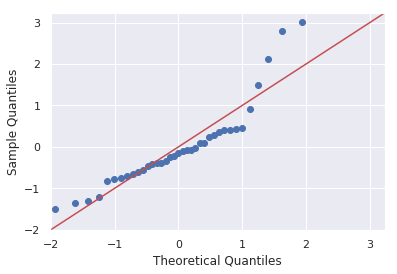

predicted vs standardized error for homoskedast.


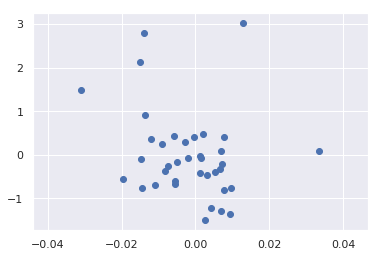

*************************
predicted vs error


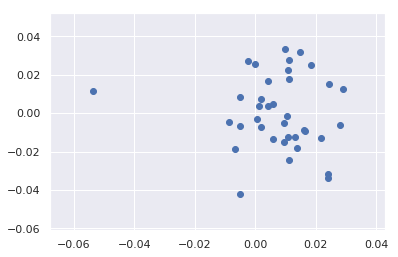

QQ plot for error normality


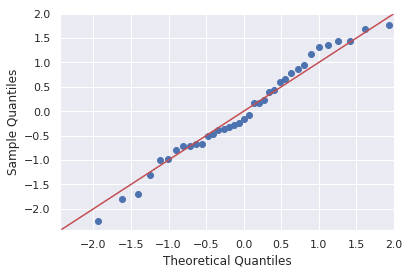

predicted vs standardized error for homoskedast.


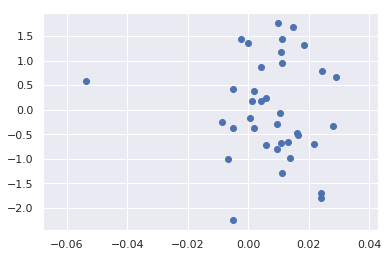

*************************


In [15]:
W,R=get_returns(beg[0],end[0])
for i in range(7):
    Y=R[i].T
    est_wt=sm.WLS(Y,X, weights=1/std**2).fit()
    error=Y-est_wt.predict()
    print('predicted vs error')
    plt.scatter(est_wt.predict(), error)
    plt.show()
    print('QQ plot for error normality')
    error=(error - np.mean(error))/np.std(error)
    sm.qqplot(error, line='45')
    plt.show()
    print('predicted vs standardized error for homoskedast.')
    plt.scatter(est_wt.predict(), error)
    plt.show()
    print('*************************')


In [ ]:
#comparison between sklearn and statsmodels. Very much the same.
from sklearn import linear_model
W,R=get_returns(beg[0],end[0])
std, factors=get_processed_factors(beg1[0],end1[0],W)
X=factors
X = sm.add_constant(X)
y=R[0].T
est=sm.WLS(y,X, weights=1/std**2).fit()
lm = linear_model.LinearRegression()
model = lm.fit(X,y, sample_weight=1/(std.T[0])**2)
#print(model.predict(X)-est.predict())
#print(model.score(X,y,sample_weight=1/(std.T[0])**2)-est.rsquared)


In [ ]:
import seaborn as sns
W_,R_=get_returns(beg[0],end[3])
cor=np.corrcoef(R_.T)
print(np.mean(cor))
print('**************')
for i in range(len(cor)):
    X=cor[i]
    print(np.mean(X))
    print(len(np.where(X>0.3)[0]))
plt.figure(figsize=(10,10))
sns.heatmap(cor,  vmin=0.25, vmax=0.35, cmap='gist_ncar',linewidths=0.9)

In [ ]:
from sklearn import linear_model

lm = linear_model.LinearRegression(fit_intercept=False)
lmm= linear_model.LinearRegression()
model = lm.fit(X,y)
modelm=lmm.fit(X,y)
#print(model1.score(X,y,sample_weight=(std.T[0])**-1))
#print(model1.score(X,y,sample_weight=None))
X1=X/std
y1=y/std
lm = linear_model.LinearRegression(fit_intercept=False)
model1 = lm.fit(X1,y1)
modelm1=lmm.fit(X1,y1)
y_hat=model.predict(X)
y1_hat=model1.predict(X1)
ym_hat=modelm.predict(X)
y1m_hat=modelm1.predict(X1)

c=np.corrcoef(y.T[0], y_hat.T[0])
c1=np.corrcoef(y1.T[0], y1_hat.T[0])
print(c)
print(c1)
print(np.where(std==np.max(std)))
plt.scatter(range(len(std)),std)

In [ ]:

methods=['averaged','barra']
weights=[0,1]
T=[0,1,2,3]
beg=[1522540800+3600+t*604800 for t in T]
end=[1522540800+(t+1)*604800 for t in T]
beg1=[1515283200+t*604800 for t in T]
end1=[1522540800+t*604800 for t in T]
DDD={}

for m in methods:
    for w in weights:
        for t in T:
            roar=str(m)+str(w)+str(t)
            DDD[roar]=[get_stats(beg[t],end[t],beg1[t],end1[t],m,w)]


ralf0=np.empty((7,))
ralf1=np.empty((7,))
ralf2=np.empty((7,))
ralf3=np.empty((7,))

for key in DDD.keys():
    if key[-1]=='0':
        ralf0=np.vstack((ralf0, DDD[key][0][3]))
        print(key,DDD[key][0][3])
ralf0=ralf0[1:]
print('*******************')
for key in DDD.keys():
    if key[-1]=='1':
        ralf1=np.vstack((ralf1, DDD[key][0][3]))
        print(key,DDD[key][0][3])
ralf1=ralf1[1:]
print('*******************')
for key in DDD.keys():
    if key[-1]=='2':
        ralf2=np.vstack((ralf2, DDD[key][0][3]))
        print(key,DDD[key][0][3])
ralf2=ralf2[1:]
print('*******************')
for key in DDD.keys():
    if key[-1]=='3':
        ralf3=np.vstack((ralf3, DDD[key][0][3]))
        print(key,DDD[key][0][3])
ralf3=ralf3[1:]

totralf=[ralf0,ralf1,ralf2,ralf3]

for i in range(4):
    win=np.argmax(totralf[i], axis=0)
    print(win)

In [ ]:
#compare R^2-performance of barra/averaged factors, weighted/non weighted regressions.

print(r2_mine_nowt)
print(r2_mine_wt)
print(r2_barra_nowt)
print(r2_barra_wt)

t=list(range(31))
fig = plt.figure(figsize=(13, 13))
plt.title('R^2 comparison')
plt.scatter(t, r2_mine_nowt, c='r', label='mine')
plt.scatter(t, r2_mine_wt, c='b', label='mine_weight')
plt.scatter(t, r2_barra_nowt, c='g', label='barra')
plt.scatter(t, r2_barra_wt, c='y', label='barra_weight')
plt.legend()
plt.savefig('R^2_comparison.png')
plt.show()

FF=np.vstack((r2_mine_nowt,r2_mine_wt,r2_barra_nowt,r2_barra_wt))
scores=np.argmax(FF,axis=0)
print(variances)
[len(np.where(scores==i)[0]) for i in range(4)]

In [ ]:
###compute covariance of factor returns###
#either compute cov of total_beta; or compute cov of beta, and attach a 1x1 block with inter.
#results are slightly different - intercept and beta are slightly correlated over time.
ess_cov=np.cov(beta.T)
ess1=np.hstack((ess_cov, np.zeros(6).reshape(-1,1)))
ess2=np.vstack((ess1, np.zeros(7).reshape(1,-1)))
ess2[-1,-1]=np.var(inter)

ess_totcov=np.cov(total_beta.T)
totfac=np.hstack((np.ones((factors.shape[0], 1)), factors))
D=np.cov(residuals, bias=1)
D1=np.var(residuals,axis=1)
D2=D.diagonal()

COV=np.dot(totfac, np.dot(ess_totcov,totfac.T)) + np.diag(D1)

In [ ]:
###compute weights of optimal portfolio, given alpha###
#ideally alpha=returns, which you don't know.
#Namely, minimize w^T.C.w-alpha.w 
#solution is w=C^{-1}.alpha
def optimal_weights(alpha):
    #alpha=np.random.rand(factors.shape[0], 1)
    COV_=np.linalg.inv(COV)
    return np.dot(COV_,alpha)
#computeoptimal portfolio return: take returns after May2nd and check performance.
def portfolio_return(alpha, days_after_may2=1):
    test_returns=[]
    for base in coins:
        for quote in quotes:
            returns=upload_log_return(1525219200+days_after_may2*86400, base, quote, 86400)
            if np.isnan(returns)==True:
                returns=0
            test_returns.append(returns)
    test_returns=np.delete(test_returns, W)
    print(test_returns)
    ignorant_returns=np.dot(alpha,test_returns)
    hedged_returns=np.dot(optimal_weights(alpha).T, test_returns)
    return ignorant_returns, hedged_returns


In [ ]:
alpha=np.zeros(76) 
alpha[6:]=1
print(alpha)
alpha/=np.sum(alpha)
#optimal_weights(alpha)
print(portfolio_return(alpha, 5))

In [ ]:
###looking for homoscedasticity: variance of errors independent of time/estimated returns:
####white test for homoscedasticity: regress squared-error against regressors, check r2.
resi=residuals**2
reg.fit(factors, resi)
residuals_hat=reg.predict(factors)
resmean=np.mean(resi,axis=0) #daily average return
tss=np.sum( (resi-resmean)**2, axis=0 ) #daily total_sum_squares
rss=np.sum( (resi- residuals_hat)**2, axis=0 ) #daily residual_sum_squares ~ var residuals
r2=1-rss/tss #daily R^2

#compute covariance of error timeseries: TT_t,s=cov(err_t,err_s).
#TT should be close to a homothety
TT=np.cov(residuals.T)
TTD=TT.diagonal()
plt.scatter(range(len(TTD)),TTD)
#on each row, pick column with maximal entry and check if it's diagonal.
#works beautifully, T is almost diagonal
MAX=np.argmax(TT,axis=0)
MAX-list(range(len(TT)))



In [ ]:
####looking for patterns in variance of returns versus marketcap.

pathh='/home/fbuonerba/factor_loadings/'
mkcap_list_usd=[]
mkcap_list_btc=[]
variance_usd=[]
variance_btc=[]
for coin in coins:
    with open(pathh+'log_mkcap_exact_'+str(coin)+'_USD_1531612800.txt')as uo:
        mcap=json.load(uo)
    mkcap_list_usd.append(mcap)
    with open(pathh+'log_mkcap_exact_'+str(coin)+'_BTC_1531612800.txt')as uoo:
        cap=json.load(uoo)
    mkcap_list_btc.append(cap)
    with open(pathh+'variance_'+str(coin)+'_USD_1524355200_1531612800_604800.txt')as uo:
        var=json.load(uo)
    variance_usd.append(var)
    with open(pathh+'variance_'+str(coin)+'_BTC_1524355200_1531612800_604800.txt')as uoo:
        varr=json.load(uoo)
    variance_btc.append(varr)

order_usd=np.argsort(np.array(mkcap_list_usd))
order_btc=np.argsort(np.array(mkcap_list_btc))
new_var_usd=[variance_usd[x] for x in order_usd]
new_var_btc=[variance_btc[x] for x in order_btc]


In [ ]:
####Outliers = HB,DIG,ODE for both USD and BTC.
plt.scatter(list(range(len(new_var_btc))), new_var_btc, c='r', label='btc')
plt.savefig('ordered_var_btc.png')

In [ ]:
plt.scatter(list(range(len(new_var_usd))), new_var_usd, c='b', label='usd')
plt.savefig('ordered_var_usd.png')

In [ ]:
#report printout
print('Definition of factors, for each coin pair:')
print('*returns_variance = var(returns_t), over weekly returns Jan 7th-Apr 1st.')
print('*returns_strength=sum_t( log(1+return_t) ) over returns as above.')
print('*returns_high_low=log( max_t(return_t)/min_t(return_t) ) over returns as above.')
print('*turnover=(total traded volume)/(average coin supply) over trades Jan 7th-Apr 1st.')
print('*log_mkcap=average_t( log(coin_supply_t*price_t) ) over weekly supply and price Jan 7th-Apr 1st.')
print('*coin_ratio=average_t(coin_supply_t/coin_supply_ever) over weekly supply as above.')
print('Factor loadings have been scaled by z-score.')
print('')
for y in df_list:    
    for x in y:
        print(x)

In [ ]:
######################################################
######################################################
######################################################

In [ ]:
#regression against each one single time, BTC/USD
factor_test=factors
r=[]
for i in range(8):
    R_test=R[i]
    beta_test=np.linalg.lstsq(factor_test,R_test.T, rcond=None)
    S=np.dot(factors,beta_test[0])
    res_test=np.linalg.norm(R_test-S)**2
    r.append(1-res_test/np.linalg.norm(R_test)**2)
r=np.array(r)
print(np.max(r), np.min(r))

In [ ]:
reg=linear_model.LinearRegression()
for i in range(6):
    fac=factors.T[i].reshape(-1,1)
    ret=R[8].T
    #print(fac.shape)
    reg.fit(fac,ret)
    temp_beta=reg.coef_[0]
    temp_inter=reg.intercept_
    print(temp_beta, temp_inter)
    print(reg.score(fac,ret))
    plt.plot(fac, ret,'o')
    plt.plot(fac, temp_beta*fac + temp_inter, 'r', label='Fitted line')
    plt.show()

In [ ]:
for t in range(88):
    print(coins[int(t/2)],quotes[t%2])
    plt.plot(range(len(R)), R.T[t])
    plt.show()